# 2.8 Discontinuous Galerkin Methods

* Use discontinuous finite element spaces to solve PDEs. 
* Allows upwind-stabilization for convection-dominated problems
* Requires additional jump terms for consistency 

Interior penalty DG form for $-\Delta u$:

$$
\DeclareMathOperator{\Div}{div}
A(u,v) = \sum_T \int_T \nabla u \nabla v
-  \sum_F \int_F \{ n \nabla u \} [v] 
-  \sum_F \int_F \{ n \nabla v \} [u] 
+ \frac{\alpha p^2}{h} \sum_F \int_F [u][v]
$$

with jump-term over facets:
$$
[u] = u_{left} - u_{right}
$$

and averaging operator
$$
\{ n \nabla u \} = \tfrac{1}{2} (n_{left} \nabla u_{left} + n_{left} \nabla u_{right})
$$

DG form for $\Div (b u)$, where $b$ is the given wind:

$$
B(u,v) = -\sum_T b u \nabla v + \sum_F \int_F b\cdot n   u^{upwind} v 
$$

In [1]:
import netgen.gui
%gui tk
from netgen.geom2d import unit_square
from ngsolve import *
mesh = Mesh(unit_square.GenerateMesh(maxh=0.3))

The space is responsible for allocating the matrix graph. Tell it that it should reserve entries for the coupling terms:

In [2]:
order=4
fes = L2(mesh, order=order, dgjumps=True)
u,v = fes.TnT()

Every facet has a master element. The value from the other element is referred to via the
`Other()` operator:

In [3]:
jump_u = u-u.Other()
jump_v = v-v.Other()
n = specialcf.normal(2)
mean_dudn = 0.5*n * (grad(u)+grad(u.Other()))
mean_dvdn = 0.5*n * (grad(v)+grad(v.Other()))

Integrals on facets are computed by setting `skeleton=True`. This iterates over all internal facets. Additionally setting `BND` iterates only over boundary facets:

In [4]:
alpha = 4
h = specialcf.mesh_size
a = BilinearForm(fes)
a += SymbolicBFI(grad(u)*grad(v))
a += SymbolicBFI(alpha*order**2/h*jump_u*jump_v, skeleton=True)
a += SymbolicBFI(alpha*order**2/h*u*v, BND, skeleton=True)
a += SymbolicBFI(-mean_dudn*jump_v -mean_dvdn*jump_u, skeleton=True)
a += SymbolicBFI(-n*grad(u)*v-n*grad(v)*u, BND, skeleton=True)
a.Assemble()

In [5]:
f = LinearForm(fes)
f += SymbolicLFI(1*v)
f.Assemble()

In [6]:
gfu = GridFunction(fes, name="uDG")
gfu.vec.data = a.mat.Inverse() * f.vec
Draw (gfu)

DG requires a lot of additional matrix entries:

In [7]:
print ("a nze:", a.mat.nze)
fes2 = L2(mesh, order=order)
a2 = BilinearForm(fes2)
a2 += SymbolicBFI(u*v)
a2.Assemble()
print ("a2 nze:", a2.mat.nze)

a nze: 18900
a2 nze: 5400


### Remarks on sparsity pattern in NGSolve

#### Remark 1: The sparsity pattern is set up a-priorily
* The sparsity pattern of a sparse matrix in NGSolve is independent of its entries (it's set up a-priorily). 
* We can have "nonzero" entries that have the value 0

Below we show the reserved memory for the sparse matrix and the (numerically) non-zero entries in this sparse matrix. 

In [8]:
fes2 = L2(mesh, order=order, dgjumps=True)
a3 = BilinearForm(fes2)
a3 += u*v*dx + (u+u.Other())*v*dx(skeleton=True)
a3.Assemble()

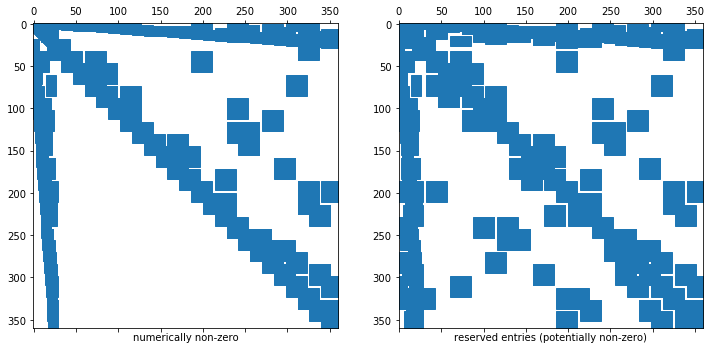

In [10]:
import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)
A = sp.csr_matrix(a3.mat.CSR())
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("numerically non-zero"); ax1.spy(A)
ax2.set_xlabel("reserved entries (potentially non-zero)"); ax2.spy(A,precision=-1)
plt.show()

#### Remark 2: Sparsity pattern with and without `dgjumps=True` is different

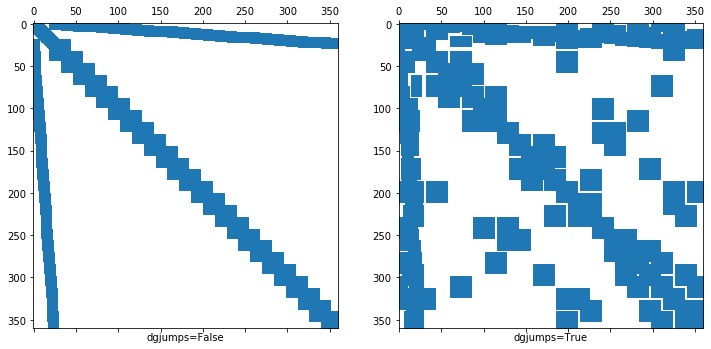

In [11]:
a1 = BilinearForm(L2(mesh, order=order, dgjumps=False)); a1.Assemble()
a2 = BilinearForm(L2(mesh, order=order, dgjumps=True)); a2.Assemble()
A1 = sp.csr_matrix(a1.mat.CSR())
A2 = sp.csr_matrix(a2.mat.CSR())
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("dgjumps=False"); ax1.spy(A1,precision=-1)
ax2.set_xlabel("dgjumps=True"); ax2.spy(A2,precision=-1)
plt.show()

#### Remark 3: Dof numbering of higher order FESpaces 

* In `NGSolve` `FESpace`s typically have a numbering where the first block of dofs corresponds to a low order subspace (which is convenient for iterative solvers). 
* For L2 this means that the first dofs correspond to the constants on elements. 

* You can turn this behavior off for some spaces, e.g. for L2 by adding the flag `all_dofs_together`.

We demonstrate this in the next comparison:

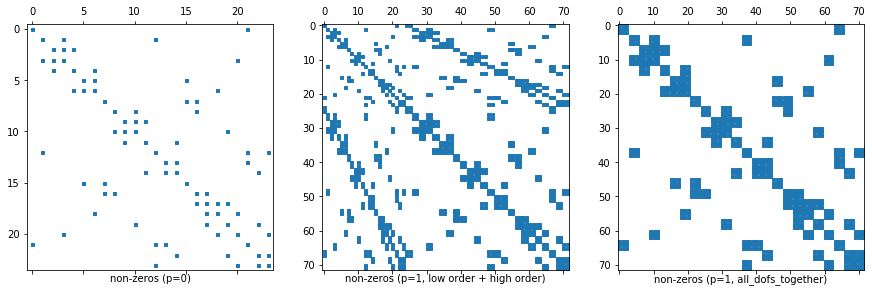

In [12]:
plt.rcParams['figure.figsize'] = (15, 15)
fig = plt.figure()
ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]

for i, (order, all_dofs_together, label) in enumerate([(0,False, "non-zeros (p=0)"),
                                                       (1,False,"non-zeros (p=1, low order + high order)"),
                                                       (1,True,"non-zeros (p=1, all_dofs_together)")]):
    a = BilinearForm(L2(mesh,order=order,dgjumps=True,all_dofs_together=all_dofs_together))
    a.Assemble()
    ax[i].spy(sp.csr_matrix(a.mat.CSR()),markersize=3,precision=-1)
    ax[i].set_xlabel(label)

Next we are solving a convection-diffusion problem:

In [13]:
alpha = 4
h = specialcf.mesh_size
acd = BilinearForm(fes)
acd += SymbolicBFI(grad(u)*grad(v))
acd += SymbolicBFI(alpha*order**2/h*jump_u*jump_v, skeleton=True)
acd += SymbolicBFI(alpha*order**2/h*u*v, BND, skeleton=True)
acd += SymbolicBFI(-mean_dudn*jump_v -mean_dvdn*jump_u, skeleton=True)
acd += SymbolicBFI(-n*grad(u)*v-n*grad(v)*u, BND, skeleton=True)

The `IfPos` checks whether the first argument is positive. Then it returns the second one, else the third one. This is used to define the upwind flux. The check is performed in every integration-point on the skeleton:

In [14]:
b = CoefficientFunction( (20,1) )
acd += SymbolicBFI(-b * u * grad(v))
uup = IfPos(b*n, u, u.Other())
acd += SymbolicBFI(b*n*uup*jump_v, skeleton=True)

In [15]:
acd.Assemble()

In [16]:
gfu = GridFunction(fes)
gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
Draw (gfu)

## Hybrid Discontinuous Galerkin methods
use additionally the *hybrid* facet variable on the skeleton:

$$
\DeclareMathOperator{\Div}{div}
A(u,\widehat u; v, \widehat v) = 
  \sum_T \int_T \nabla u \nabla v
- \sum_T \int_{\partial T} n \nabla u (v-\widehat v)
- \sum_T \int_{\partial T} n \nabla v (u-\widehat u)
+ \frac{\alpha p^2}{h} \sum_F \int_F (u-\widehat u)(v-\widehat v)
$$

the jump-term is now replaced by the difference $u - \widehat u$.

No additional matrix entries across elements are produced. Dirichlet boundary conditions are set as usual to the facet variable:

In [17]:
order=4
V = L2(mesh, order=order)
F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top")
fes = FESpace([V,F])
u,uhat = fes.TrialFunction()
v,vhat = fes.TestFunction()

Now, the jump is the difference between element-term and facet-term:

In [18]:
jump_u = u-uhat
jump_v = v-vhat

In [19]:
alpha = 4
condense = True
h = specialcf.mesh_size
n = specialcf.normal(mesh.dim)

a = BilinearForm(fes, eliminate_internal=condense)
a += SymbolicBFI(grad(u)*grad(v))
a += SymbolicBFI(alpha*order**2/h*jump_u*jump_v, element_boundary=True)
a += SymbolicBFI(-grad(u)*n*jump_v - grad(v)*n*jump_u, element_boundary=True)

b = CoefficientFunction( (20,1) )
a += SymbolicBFI(-b * u * grad(v))
uup = IfPos(b*n, u, uhat)
a += SymbolicBFI(b*n*uup*jump_v, element_boundary=True)
a.Assemble()

f = LinearForm(fes)
f += SymbolicLFI(1*v)
f.Assemble()

gfu = GridFunction(fes)

print ("A non-zero elements:", a.mat.nze)

A non-zero elements: 4650


In [20]:
if not condense:
    inv = a.mat.Inverse(fes.FreeDofs(), "umfpack")
    gfu.vec.data = inv * f.vec
else:
    f.vec.data += a.harmonic_extension_trans * f.vec 
    
    inv = a.mat.Inverse(fes.FreeDofs(True), "umfpack")
    gfu.vec.data = inv * f.vec
    
    gfu.vec.data += a.harmonic_extension * gfu.vec
    gfu.vec.data += a.inner_solve * f.vec

Draw (gfu.components[0], mesh, "u-HDG")